
# Table of Contents

### Load Python Packages
### Download Data
### Preprocess Data
### Problem Definition
### Build Environment
### Implement DRL Algorithms
### Backtesting Performance


In [5]:
import sys
sys.path.append("FinRL-Library")

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.neo_finrl.data_processor import DataProcessor
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.apps import config


C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Open AI gym<br />
## https://gym.openai.com <br />
<br />

# German Aerospace Center (DLR) - Institute of Robotics and Mechatronics (RM)<br />
## Stable Baseline<br />
<br />

# AI4Finance Foundation<br />
## Financial Feature engineering and algorithems<br />

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import gym
from gym import spaces
from gym.utils import seeding
from copy import deepcopy
import pickle

#added a new comment
matplotlib.use("Agg")

from torch.nn import Softsign, ReLU
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger

import multiprocessing

import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-08-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()
df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4


In [8]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [9]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.0,100.0,66.666667,100.0,0.0


In [10]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-06-01')
print(len(train))
print(len(trade))

75480
18210


## Defining the problem statement:

Action : Buy / Sell / Hold   <br />a : $\epsilon${1,-1,0}

<br /> hmax = 10

<br />a : $\epsilon${-10,0,10}

<br />
state space : total stocks in set * unique time steps * action

what are we trying to optimize:
<br />
portfolio value = $100 <br/>

p(v) = v_{t+1} - v_{t}

In [11]:
class StockTradingEnvV2(gym.Env):


    """
    Creating a stock trading environment from OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): commission paid for each transaction
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step.
        initial_amount: (int, float): Principal cash amount to start with
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe.
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash


    tests:
        after reset, static strategy should result in same metrics

        buy zero should result in no costs, no assets purchased
        given no change in prices, no change in asset values
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        transaction_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        turbulence_threshold=None,
        print_verbosity=10,
        reward_scaling=1e-4,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        out_of_cash_penalty=None,
        cache_indicator_data = True
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        if out_of_cash_penalty is None:
            out_of_cash_penalty=-initial_amount*0.5
        self.out_of_cash_penalty = out_of_cash_penalty
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.close_index = self.daily_information_cols.index("close")
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.episode = -1  # initialize so we can call reset
        self.seed()
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")
        

    def seed(self):
        pass


    def reset(self):
        self.sum_trades = 0
        self.date_index = 0
        self.episode += 1
        self.actions_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            'reward': []
        }
        self.state_memory.append(
            np.array(
                [self.initial_amount]
                + [0] * len(self.assets)
                + self.get_date_vector(self.date_index)
            )
        )
        return [0 for _ in range(self.state_space)]

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v
    
    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information['reward'][-1]
        cash_pct = self.account_information['cash'][-1]/self.account_information['total_assets'][-1]
        rec = [self.episode, self.date_index, reason, f"${int(self.account_information['total_assets'][-1])}",f"${terminal_reward:0.2f}", f"{cash_pct*100:0.2f}%"]

        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def step(self, actions):
        #print header only first time
        if self.printed_header is False:
            self.template = "{0:8}|{1:10}|{2:15}|{3:7}|{4:10}|{5:10}" # column widths: 8, 10, 15, 7, 10
            print(self.template.format("EPISODE", "STEPS", "TERMINAL_REASON", "TOT_ASSETS", "TERMINAL_REWARD_unsc", "CASH_PCT"))
            self.printed_header = True

        # define terminal function in scope so we can do something about the cycle being over
        def return_terminal(reason='Last Date', extra_reward=0):

            state = self.state_memory[-1]
            reward = 0
            reward += extra_reward
            self.log_step(reason = reason, terminal_reward= reward)
            reward = reward*self.reward_scaling
            # Add outputs to logger interface
            reward_pct = self.account_information['total_assets'][-1]/self.initial_amount
            '''logger.record("environment/total_reward_pct", (reward_pct-1)*100)
            logger.record("environment/daily_trades", self.sum_trades/self.date_index)
            logger.record("environment/completed_steps", self.date_index)
            logger.record("environment/sum_rewards", np.sum(self.account_information['reward']))'''
            return state, reward, True, {}

        # print if it's time.
        if (self.date_index + 1) % self.print_verbosity == 0:
            self.log_step(reason = 'update')

        #if we're at the end
        if self.date_index == len(self.dates) - 1:
            #if we hit the end, set reward to total gains (or losses)
            terminal_reward = self.account_information['total_assets'][-1]-self.initial_amount
            return return_terminal(extra_reward = terminal_reward)
        else:
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert (min(holdings)>=0)
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))

            # compute current value of holdings
            asset_value = np.dot(holdings, closings)

            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            if self.date_index==0:
                reward = 0
            else:
                reward = (
                    begin_cash + asset_value - self.account_information["total_assets"][-1]
                )

            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information['reward'].append(reward)

            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions)

            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))
            self.sum_trades += np.sum(np.abs(actions))

            # compute our proceeds from sales, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.transaction_cost_pct
            coh = begin_cash + proceeds

            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.transaction_cost_pct

            # if we run out of cash, end the cycle and penalize
            if (spend + costs) > coh:
                return return_terminal(reason = 'CASH SHORTAGE',
                    extra_reward=self.out_of_cash_penalty,
                )

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions
            self.date_index += 1
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            reward = reward * self.reward_scaling
            return state, reward, False, {}

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def get_multiproc_env(self, n = 10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method = 'fork')
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        self.account_information["date"] = self.dates[: len(self.account_information['cash'])]
        return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        return pd.DataFrame(
            {"date": self.dates[: self.date_index], "actions": self.actions_memory}
        )

In [ ]:
print(StockTradingEnvV2.__doc__)

In [12]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

e_train_gym = StockTradingEnvV2(df = train, 
                              hmax = 100, 
                              out_of_cash_penalty=-1e6,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

caching data
data cached!


In [13]:
# let's do multiprocessing with n_cores-1
n_cores = multiprocessing.cpu_count() - 2
print(f"using {n_cores} cores")


env_train, _ = e_train_gym.get_sb_env()

using 6 cores


In [14]:
agent = DRLAgent(env = env_train)
print(config.PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


In [15]:
ppo_params ={'n_steps': 128, 
             'ent_coef': 0.01, 
             'learning_rate': 0.00025, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024, 1024, 1024], 
#     "squash_output": True
}

model = agent.get_model("ppo",  model_kwargs = ppo_params, policy_kwargs = policy_kwargs, verbose = 0)
model = model.load("quicksave_ppo_dow.model")

{'n_steps': 128, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256, 'gamma': 0.99}


C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\ppo\ppo.py:137: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


AttributeError: 'Box' object has no attribute '_shape'

In [16]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [17]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.278200
std        33.999916
min         0.000000
25%        15.233869
50%        25.166816
75%        39.290032
max       332.849108
Name: turbulence, dtype: float64

In [18]:
def DRL_prediction(model, environment):
    test_env, test_obs = environment.get_sb_env()
    """make a prediction"""
    account_memory = []
    actions_memory = []
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs)
        #account_memory = test_env.env_method(method_name="save_asset_memory")
        #actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if not dones[0]:
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        if dones[0]:
            print("hit end!")
            break
    return account_memory[0], actions_memory[0]

In [19]:
trade = data_split(processed, '2019-01-01','2021-06-01')
e_trade_gym = StockTradingEnvV2(df = trade,hmax = 10,initial_amount = 1000000,
                              daily_information_cols = information_cols,
                              print_verbosity = 500)

df_account_value, df_actions = DRL_prediction(model=model,
                        environment = e_trade_gym,)

caching data
data cached!
EPISODE |STEPS     |TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
       1|       499|update         |$1040865|$-4380.76 |46.87%    
       1|       606|Last Date      |$1128758|$128758.02|38.26%    
hit end!


In [20]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2019-01-02
1,993195.465716,6659.296600,9.998548e+05,-145.237684,2019-01-03
2,991864.819030,8198.712095,1.000064e+06,208.768809,2019-01-04
3,983245.311836,16830.752866,1.000076e+06,12.533576,2019-01-07
4,979279.852055,20977.856573,1.000258e+06,181.643926,2019-01-08
5,981072.448824,19157.875551,1.000230e+06,-27.384253,2019-01-09
6,978196.375176,22046.273004,1.000243e+06,12.323806,2019-01-10
7,969385.123133,30775.222910,1.000160e+06,-82.302137,2019-01-11
8,971359.111573,28661.160875,1.000020e+06,-140.073596,2019-01-14
9,969970.756953,29997.978817,9.999687e+05,-51.536677,2019-01-15


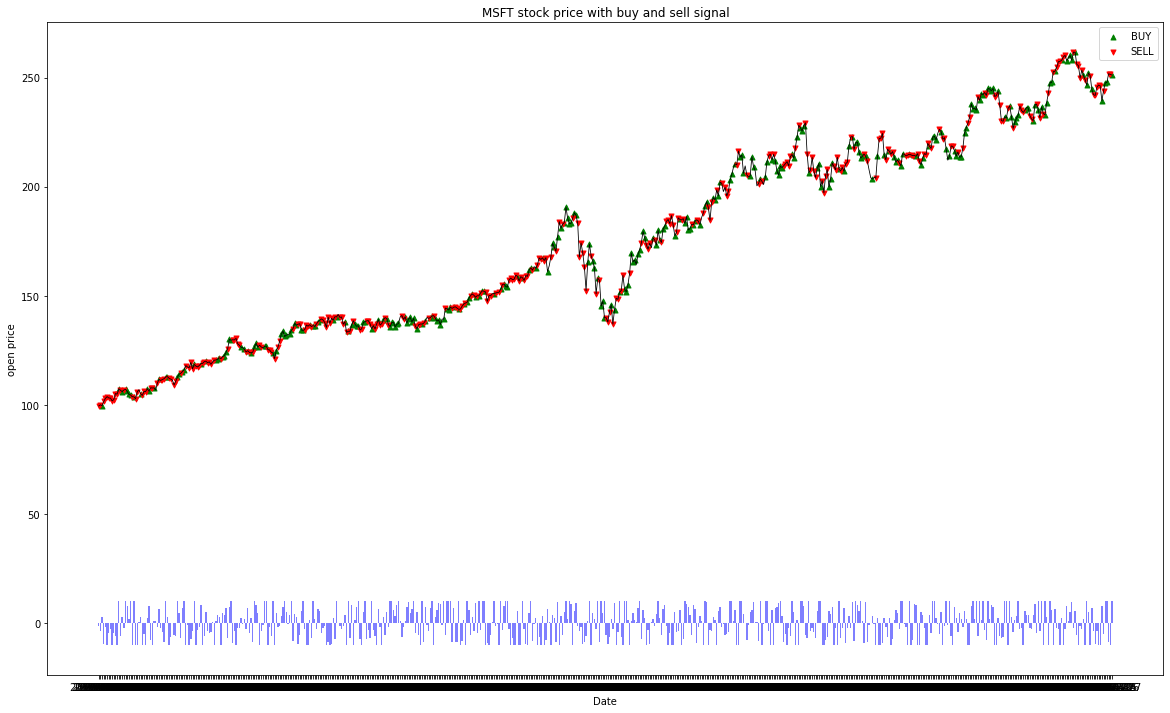

In [26]:
action_plot_df = df_actions.copy()
action_plot_df['buy_sell'] = action_plot_df['actions'].apply(
    lambda x: np.clip(x, -1, 1)[18])
action_plot_df['actions'] = action_plot_df['actions'].apply(lambda x: x[18])
action_plot_df = pd.merge(action_plot_df, trade[trade['tic'] == 'MSFT'], how='left', on='date')[
    ["date", "actions", "open", "buy_sell"]]

plt.figure(figsize=(20, 12))
plt.plot(action_plot_df['date'], action_plot_df['open'],
         linewidth=0.8, color='black')
plt.scatter(action_plot_df.loc[action_plot_df['buy_sell'] == 1, 'date'].values, action_plot_df.loc[action_plot_df['buy_sell'] ==
                                                                                                   1, 'open'].values, label='BUY', color='green', s=25, marker="^")
plt.scatter(action_plot_df.loc[action_plot_df['buy_sell'] == -1, 'date'].values, action_plot_df.loc[action_plot_df['buy_sell']
                                                                                                    == -1, 'open'].values, label='SELL', color='red', s=25, marker="v")

plt.bar(action_plot_df['date'].values, action_plot_df['actions'].values,color='blue', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('open price')
plt.title('MSFT stock price with buy and sell signal')
plt.show()


In [23]:
df_actions.to_dict(orient = 'rows')[:3]

C:\Users\ArjunSingh\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


[{'date': '2019-01-02',
  'actions': array([ -5.1900573 ,  -9.609827  ,  -2.975302  ,   0.30506903,
           5.777234  ,  10.        , -10.        ,   0.48215505,
         -10.        ,   4.255442  ,   3.856305  ,   3.871532  ,
          10.        ,  10.        ,   6.447983  ,  -4.483319  ,
           1.2254008 , -10.        ,  -1.2501433 , -10.        ,
          10.        , -10.        ,  -5.891009  ,  -1.2871104 ,
          -1.0769504 ,  -5.296145  ,   6.1026726 ,   9.550589  ,
          -9.250562  ,   6.897848  ], dtype=float32)},
 {'date': '2019-01-03',
  'actions': array([ -3.6681275 ,  -4.608831  , -10.        ,  -0.44060862,
          -9.552305  , -10.        ,   0.8736936 ,  -0.9301728 ,
         -10.        , -10.        ,   0.39030766,  -3.093018  ,
           3.3009653 ,  -6.243482  ,  10.        ,  -8.472196  ,
          10.        ,  -6.6613145 ,  -3.5842867 ,  10.        ,
         -10.        ,   2.3475962 ,  -8.420866  ,  -2.256006  ,
          -5.298646  ,  -3.103

In [24]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.051656
Cumulative returns     0.128758
Annual volatility      0.081611
Sharpe ratio           0.659066
Calmar ratio           0.428588
Stability              0.273203
Max drawdown          -0.120525
Omega ratio            1.148723
Sortino ratio          0.913185
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.076720
Daily value at risk   -0.010069
dtype: float64


==============Benchmark our results against DJI===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (605, 8)


Start date,2019-01-02
End date,2021-05-26
Total months,28
,Backtest
Annual return,5.028%
Cumulative returns,12.498%
Annual volatility,8.165%
Sharpe ratio,0.64
Calmar ratio,0.42
Stability,0.27
Max drawdown,-12.053%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.05,2020-01-17,2020-03-23,2020-11-09,212
1,2.25,2021-05-10,2021-05-12,NaT,NaN
2,2.13,2019-07-15,2019-08-14,2019-11-26,97
3,1.79,2021-01-12,2021-01-29,2021-03-08,40
4,1.33,2020-11-16,2020-11-20,2020-11-24,7


C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


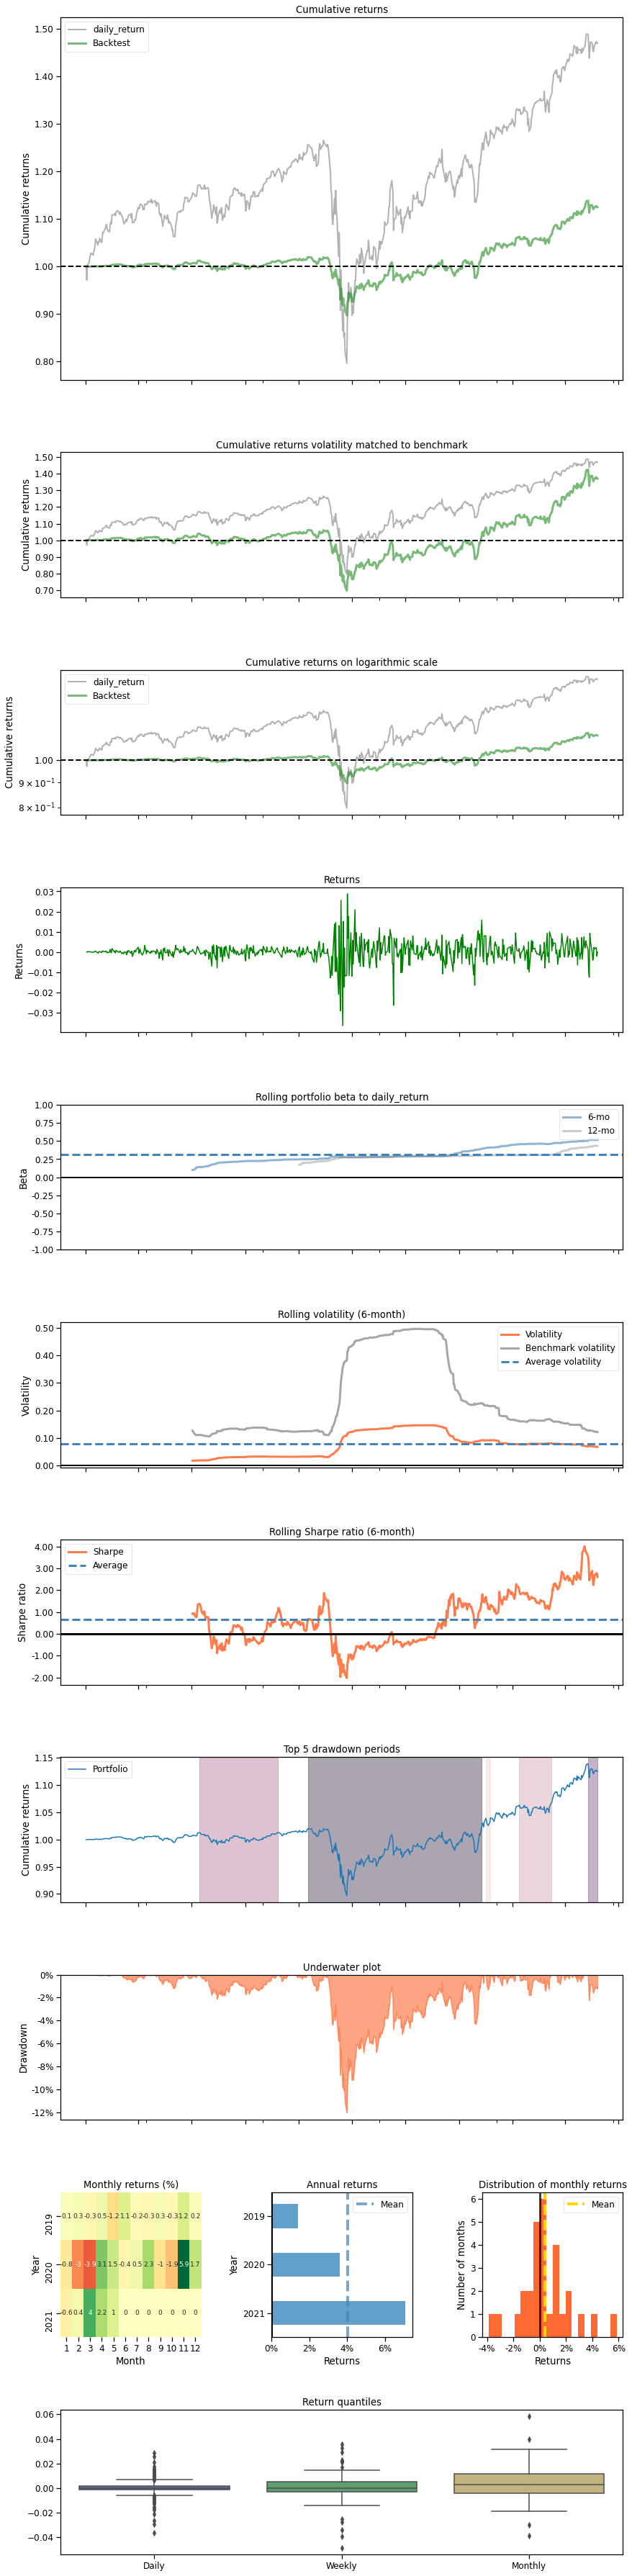

In [25]:
print("==============Benchmark our results against DJI===========")

%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             
             baseline_start = df_account_value.date.values[0],
             baseline_end = df_account_value.date.values[-1], value_col_name = 'total_assets')